In [2]:
import datetime
import json
import boto3
import io
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns

import requests
import zipfile

In [3]:
# 取得する日付
DL_Date = "20190218"
# 対象とする限月
MatMon = "201904"

# オプション理論価格等情報
#    利用ガイド：http://www.jpx.co.jp/markets/derivatives/option-price/01.html
#    一覧: http://www.jpx.co.jp/markets/derivatives/option-price/index.html

file = "ose{}tp".format(DL_Date)
url = "http://www.jpx.co.jp/markets/derivatives/option-price/data/{}.zip".format(file)

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [4]:
def strip(text):
    try:
        return text.strip()
    except AttributeError:
        return text

In [5]:
# ヘッダー名 (変数名順)
#     商品コード, 商品タイプ, 限月, 権利行使価格, 予備
#     プットオプション: 銘柄コード, 終値, 予備, 理論価格, ボラティリティ
#     コールオプション: 銘柄コード, 終値, 予備, 理論価格, ボラティリティ
#     原資産終値, 基準ボラティリティ
colName = ("CODE","TYPE","MATURITY","STRIKE", "RSV", 
          "PUT_CODE", "PUT_PRICE", "PUT_RSV", "PUT_TPRICE", "PUT_VOLATILITY",
          "CALL_CODE","CALL_PRICE","CALL_RSV","CALL_TPRICE","CALL_VOLATILITY",
          "F225_PRICE", "Base_VOL")

df_raw = pd.read_csv(file+".csv", names=colName,
                converters = {'CODE' : strip,
                              'TYPE' : strip})
df_raw.head()

,CODE,TYPE,MATURITY,STRIKE,RSV,PUT_CODE,PUT_PRICE,PUT_RSV,PUT_TPRICE,PUT_VOLATILITY,CALL_CODE,CALL_PRICE,CALL_RSV,CALL_TPRICE,CALL_VOLATILITY,F225_PRICE,Base_VOL
0,NK225E,OOP,201903,8000.0,,134158018,0.0,0.0,0.00,0.9413,144158018,0.0,0.0,13266.57,2.135210,21281.85,0.1593
1,NK225E,OOP,201903,9000.0,,184039018,0.0,0.0,0.01,0.9413,194039018,0.0,0.0,12266.61,1.896334,21281.85,0.1593
2,NK225E,OOP,201903,9500.0,,184039518,0.0,0.0,0.03,0.9413,194039518,0.0,0.0,11766.65,1.786830,21281.85,0.1593
3,NK225E,OOP,201903,10000.0,,184030018,0.0,0.0,0.11,0.9413,194030018,0.0,0.0,11266.74,1.682957,21281.85,0.1593
4,NK225E,OOP,201903,10500.0,,184030518,0.0,0.0,0.29,0.9413,194030518,0.0,0.0,10766.93,1.584113,21281.85,0.1593


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9953 entries, 0 to 9952
Data columns (total 17 columns):
CODE               9953 non-null object
TYPE               9953 non-null object
MATURITY           9953 non-null int64
STRIKE             9953 non-null float64
RSV                9953 non-null object
PUT_CODE           9953 non-null int64
PUT_PRICE          9953 non-null float64
PUT_RSV            9953 non-null float64
PUT_TPRICE         9953 non-null float64
PUT_VOLATILITY     9953 non-null float64
CALL_CODE          9953 non-null int64
CALL_PRICE         9953 non-null float64
CALL_RSV           9953 non-null float64
CALL_TPRICE        9953 non-null float64
CALL_VOLATILITY    9953 non-null float64
F225_PRICE         9953 non-null float64
Base_VOL           9953 non-null float64
dtypes: float64(11), int64(3), object(3)
memory usage: 1.3+ MB


In [7]:
df_raw = df_raw.query("MATURITY == %s & CODE==\"NK225E\""%MatMon)\
    .drop(['RSV','PUT_RSV','CALL_RSV','PUT_CODE','CALL_CODE','CODE','TYPE','MATURITY'], 1)

In [8]:
df_p = df_raw[["STRIKE","PUT_PRICE","PUT_TPRICE", "PUT_VOLATILITY","F225_PRICE", "Base_VOL"]]\
    .rename(columns={'PUT_PRICE': 'OP_PRICE', 'PUT_TPRICE':'OP_TPRICE', 'PUT_VOLATILITY':'OP_VOL'})
df_p['CALL'] = False
df_c = df_raw[["STRIKE","CALL_PRICE","CALL_TPRICE", "CALL_VOLATILITY","F225_PRICE", "Base_VOL"]]\
    .rename(columns={'CALL_PRICE': 'OP_PRICE', 'CALL_TPRICE':'OP_TPRICE', 'CALL_VOLATILITY':'OP_VOL'})
df_c['CALL'] = True
df = df_p.append(df_c).query("OP_PRICE > 1.0 & STRIKE < 25000 & STRIKE >= 22000")
del (df_p,df_c)
df.head()

,STRIKE,OP_PRICE,OP_TPRICE,OP_VOL,F225_PRICE,Base_VOL,CALL
145,22000.0,1090.0,1089.45,0.144764,21281.85,0.1593,False
145,22000.0,165.0,165.00,0.150001,21281.85,0.1593,True
146,22125.0,135.0,134.99,0.148234,21281.85,0.1593,True
147,22250.0,110.0,110.00,0.146902,21281.85,0.1593,True
148,22375.0,92.0,91.99,0.147358,21281.85,0.1593,True


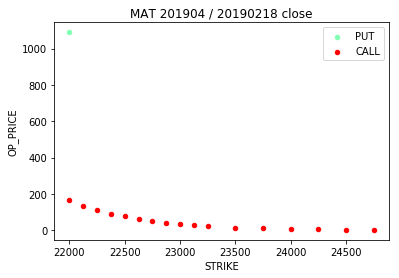

In [9]:
cmap = plt.get_cmap('rainbow')
fig, ax = plt.subplots()

for i, (key, group) in enumerate(df.groupby(['CALL']), start=1):
    ax = group.plot(ax=ax, kind='Scatter', x='STRIKE', y='OP_PRICE',color=cmap(i / 2.0),label = "CALL" if key else "PUT")
    
plt.title(u"MAT %s / %s close"%(MatMon, DL_Date))
fig.patch.set_facecolor('white') 
plt.show()